# 2주차 과제
- 사용 data :
- 막코드와 torch function 모두 사용
- mini batch, initializing, loss function, accuracy 수치 시각화

In [ ]:
! pip install d2l

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import os
import glob
#from d2l import torch as d2l

## 3.1. Image Classification Dataset

### 3.1.0. Read Dataset

In [ ]:
# img size 350*350으로 resize
trans = transforms.Compose([transforms.ToTensor(),transforms.Resize((350,350))])
pet_train = torchvision.datasets.OxfordIIITPet(root="../data", split='trainval', target_types='category',transform=trans, download=True)
pet_test = torchvision.datasets.OxfordIIITPet(root="../data", split='test', target_types='category',transform=trans, download=True)

### 3.1.1. Preprocessing

In [4]:
# 이후 transforms 과정에서 이미지들의 정규화를 위해 mean, std 계산
mean = [np.mean(x.numpy(), axis=(1,2)) for x,_ in pet_train]
std = [np.std(x.numpy(), axis=(1,2)) for x,_ in pet_train]

mean1 = np.mean([m[0] for m in mean])
mean2 = np.mean([m[1] for m in mean])
mean3 = np.mean([m[2] for m in mean])

std1 = np.mean([s[0] for s in std])
std2 = np.mean([s[1] for s in std])
std3 = np.mean([s[2] for s in std])

print(mean1, mean2, mean3)
print(std1, std2, std3)

0.47827613 0.4458522 0.3956854
0.22845784 0.22535047 0.2270727


In [5]:
print(len(pet_train))
print(len(pet_test))

3680
3669


In [6]:
# 이미지마다 크기를 통일시켜줌
print(pet_train[5][0].shape)
print(pet_train[6][0].shape)

torch.Size([3, 350, 350])
torch.Size([3, 350, 350])


In [ ]:
! pip install matplotlib==3.1.3

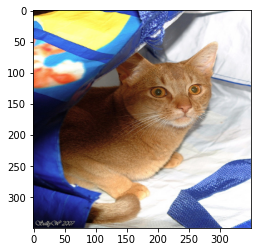

In [8]:
# image data 배열의 형태가 달라서 transpose 필요!
ex_img = pet_train[0][0].numpy()
plt.imshow(np.transpose(ex_img, (1,2,0)))

In [9]:
img_list = glob.glob('../data/oxford-iiit-pet/images/*.jpg')
print(len(img_list))

7390


In [61]:
def get_pet_label(labels):
  text_label = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 
                'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog',
                'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel',
                'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond',
                'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed',
                'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
  return [text_label[int(i)] for i in labels]

In [67]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=2): 
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(np.transpose(img.numpy(), ((1,2,0))))
        else:
# PIL Image
            ax.imshow(np.transpose(img, ((1,2,0))))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe10db46c50>,
      dtype=object)

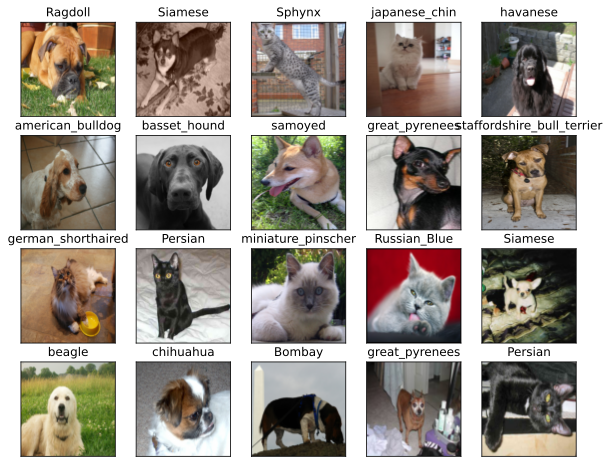

In [68]:
X, y = next(iter(data.DataLoader(pet_train, shuffle=True, batch_size=20)))
show_images(X.reshape(20,3,350,350), 4, 5, titles = get_pet_label(y))

### 3.1.2 Putting All Things Together

In [13]:
def load_pet_img(batch_size):
  trans = transforms.Compose([transforms.ToTensor(), transforms.Resize((350,350)), transforms.Normalize([mean1, mean2, mean3], [std1, std2, std3])])
  pet_train = torchvision.datasets.OxfordIIITPet(root="../data", split='trainval', target_types='category',transform=trans, download=True)
  pet_test = torchvision.datasets.OxfordIIITPet(root="../data", split='test', target_types='category',transform=trans, download=True)

  return (data.DataLoader(pet_train, batch_size, shuffle=True),
          data.DataLoader(pet_test, batch_size, shuffle=True))

In [14]:
train_iter, test_iter = load_pet_img(32)

In [15]:
for X, y in train_iter:
  print(X.shape, X.dtype, y.shape, y.dtype)
  break

torch.Size([32, 3, 350, 350]) torch.float32 torch.Size([32]) torch.int64


## 3.2. Softmax Regression from Scratch

In [16]:
import torch
from IPython import display
from d2l import torch as d2l

In [17]:
batch_size = 256
train_iter, test_iter = load_pet_img(batch_size)

In [18]:
for X, y in test_iter:
  print(X.shape, X.dtype, y.shape, y.dtype)
  break

torch.Size([256, 3, 350, 350]) torch.float32 torch.Size([256]) torch.int64


### 3.2.1. Initialize Model Parameter
Each example in the raw dataset is a 350 × 350 × 3 image. In this section, we will flatten each image, treating them as vectors of length 367500. <br>

In softmax regression, we have as many outputs as there are classes. Because our dataset has 37 classes, our network will have an output dimension of 37. <br>

Consequently, our weights will constitute a 367500 × 37 matrix and the biases will constitute a 1 × 37 row vector.

In [19]:
# Oxford iiiT pet dataset에서 설정한 img size, class 개수
num_input = 3*350*350
num_output = 37

In [69]:
W = torch.normal(0,0.01, size=(num_input, num_output), requires_grad=True)
b = torch.zeros(num_output, requires_grad=True)

### 3.2.2. Define Softmax Operation

In [21]:
X = torch.tensor([[1.0,2.0,3.0],[4.0,5.0,6.0]])
print(X.sum(0, keepdim=True))
print(X.sum(1, keepdim=True))

tensor([[5., 7., 9.]])
tensor([[ 6.],
        [15.]])


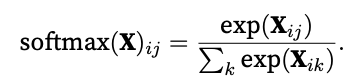

Step1. Exponentiate (torch.exp) <br>

Step2. 각 row의 값의 합을 구함 (=정규화 상수)<br>

Step3. 각 값을 정규화 상수로 나눈다
<br>

#### 어떤 random한 값을 입력해도 non-negative number를 반환하고, 모든 값의 합은 1이 되도록 한다

In [22]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1, keepdim=True)
  return X_exp/partition

In [23]:
X = torch.normal(0,1,(2,5))  #정규분포를 가지는 2*5 크기의 tensor 생성
X_prob = softmax(X)

print(X_prob)
print(X_prob.sum(1)) #각 batch에서 softmax 결과의 합이 1임을 확인

tensor([[0.2349, 0.0746, 0.1477, 0.2460, 0.2968],
        [0.1766, 0.4386, 0.1626, 0.1743, 0.0479]])
tensor([1.0000, 1.0000])


### 3.2.3. Define Model

In [24]:
b.shape

torch.Size([37])

In [25]:
# X : [350,350,3] --> X.reshape :: [1,367500]
# W : [367500, 37]
# b : [1,37]
def net(X):
  return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

### 3.2.4. Define Loss Function (Cross-Entropy Loss)
Below, we create sample data y_hat with 2 examples of predicted probabilities over 3 classes and their corresponding labels y. <br>

With y we know that in the first example the first class is the correct prediction and in the second example the third class is the ground-truth. <br>

Using y as the indices of the probabilities in y_hat, we pick the probability of the first class in the first example and the probability of the third class in the second example.

In [26]:
y = torch.tensor([0, 2])  #실제 : [0,2]
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])  #예측 : [2,2]
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [27]:
def cross_entropy(y_hat, y):
  return  (-1)*torch.log(y_hat[range(len(y_hat)), y])
    
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### 3.2.5. Classification Accuracy

Given the predicted probability distribution y_hat, we typically choose the class with the highest predicted probability whenever we must output a hard prediction. 
<br>

When predictions are consistent with the label class y, they are correct. The classification accuracy is the fraction of all predictions that are correct. Although it can be difficult to optimize accuracy directly (it is not differentiable), it is often the performance measure that we care most about, and we will nearly always report it when training classifiers. <br>

To compute accuracy we do the following. First, if y_hat is a matrix, we assume that the second dimension stores prediction scores for each class. We use argmax to obtain the predicted class by the index for the largest entry in each row.<br>
Then we compare the predicted class with the ground truth y elementwise. Since the equality operator == is sensitive to data types, we convert y_hatʼs data type to match that of y. The result is a tensor containing entries of 0 (false) and 1 (true). Taking the sum yields the number of correct predictions.

In [28]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])  
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [29]:
def accuracy(y_hat, y):
  if len(y_hat.shape)>1 and y_hat.shape[1]>1:   
    y_hat = y_hat.argmax(axis=1)   #y_hat이 matrix이면 그 Row의 가장 큰 값(argmax)을 사용
    
  cmp = y_hat.type(y.dtype) == y  #y_hat의 dtpye을 y와 통일시킴 / cmp : True or False
  return float(cmp.type(y.dtype).sum())  

We will continue to use the variables y_hat and y defined before as the predicted probability distributions and labels, respectively. <br>

We can see that the first exampleʼs prediction class is 2 (the largest element of the row is 0.6 with the index 2), which is inconsistent with the actual label, 0.<br>
The second exampleʼs prediction class is 2 (the largest element of the row is 0.5 with the index of 2), which is consistent with the actual label, 2. Therefore, the classification accuracy rate for these two examples is 0.5.

In [30]:
# 한개는 맞고 한개는 틀림 :: accuracy = 0.5
accuracy(y_hat, y) / len(y)

0.5

In [31]:
class Accumulator:
  '''
  utility class to accumulate sums over multiple variables.
  '''
  def __init__(self,n):
    self.data = [0.0]*n

  def add(self, *args):
    self.data  = [a + float(b) for a,b in zip(self.data, args)]

  def reset(self):
    self.data = [0.0]*len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [32]:
def eval_acc(net, data_iter):
  if isinstance(net, torch.nn.Module):
    net.eval()
    '''
    evaluation mode :: evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
    즉, dropout, batchnorm을 비활성화(train에서만 사용되는 layer)
    ''' 
  metric = Accumulator(2)  
  with torch.no_grad():
    for X,y in data_iter:
      metric.add(accuracy(net(X), y), y.numel())  #numel : input tensor의 전체 element 개수

  return metric[0]/metric[1]

In [33]:
eval_acc(net, test_iter)
# 1/37 = 0.02702

0.02698282910874898

### 3.2.6. Training

In [34]:
def train_epoch(net, train_iter, loss, updater):
  if isinstance(net, torch.nn.Module):
    net.train()   #train이 가능한 모드로 설정
  metric = Accumulator(3)  #3개의 값을 저장

  for X,y in train_iter:
    y_hat = net(X)
    l = loss(y_hat, y)

    # torch 내장 module 사용
    if isinstance(updater, torch.optim.Optimizer):
      updater.zero_grad()
      #updater.grad = None
      l.mean().backward(retain_graph=True)
      updater.step()

    else:
      #net.cleargrads()
      #updater.grad = None
      l.sum().backward(retain_graph=True)
      updater(X.shape[0])  #무슨 의미???

    # loss, accuracy, element 개수 저장
    torch.autograd.set_detect_anomaly(True)  # NaN Loss가 발생했을 때 학습 중단
    metric.add(float(l.sum()), accuracy(y_hat,y), y.numel())

  # 평균 loss, 평균 accuracy 출력
  return metric[0]/metric[2], metric[1]/metric[2]


Before showing the implementation of the training function, we define a utility class that plot data in animation. Again, it aims to simplify code in the rest of the book.

In [35]:
from d2l import torch as d2l
from IPython import display

In [36]:
# plotting을 위한 class

class Animator:
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
               ylim=None, xscale='linear',yscale='linear', fmts=('-','m--','g-','r:'),
               nrows=1, ncols=1, figsize=(7,5)):
    if legend is None:
      legend = []
    d2l.use_svg_display()
    self.fig, self.axes = d2l.plt.subplots(nrows,ncols,figsize=figsize)

    if nrows * ncols == 1:
      self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
    self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    self.X, self.Y, self.fmts = None, None, fmts
    
  def add(self, x, y):
      # Add multiple data points into the figure
      if not hasattr(y, "__len__"):
          y = [y]
      n = len(y)
      if not hasattr(x, "__len__"):
          x = [x] * n
      if not self.X:
          self.X = [[] for _ in range(n)]
      if not self.Y:
          self.Y = [[] for _ in range(n)]
      for i, (a, b) in enumerate(zip(x, y)):
        if a is not None and b is not None:
          self.X[i].append(a)
          self.Y[i].append(b)
      self.axes[0].cla()
      for x, y, fmt in zip(self.X, self.Y, self.fmts):
        self.axes[0].plot(x, y, fmt)
      self.config_axes()
      display.display(self.fig)
      display.clear_output(wait=True)

In [37]:
from tqdm import tqdm

In [47]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
  animator1 = Animator(xlabel='epoch',xlim=[1,num_epochs], ylim=[0.0,1.0],
                      legend = ['train_acc', 'test_acc'])
  animator2 = Animator(xlabel='epoch',xlim=[1,num_epochs], ylim=[0,100],
                      legend = 'train_loss')
  
  for epoch in tqdm(range(num_epochs)):
    train_metrics = train_epoch(net, train_iter, loss, updater)
    train_loss, train_acc = train_metrics
    test_acc = eval_acc(net, test_iter)

    animator1.add(epoch+1, (train_acc,)+(test_acc,))
    animator2.add(epoch+1, train_loss)
    
    print(f'train loss : {train_loss} , train acc : {train_acc}, test acc : {test_acc}')
  
  # assert :: 
  #assert train_loss < 10, train_loss
  #assert train_acc <= 1 and train_acc > 0.2, train_acc
  #assert test_acc <=1 and test_acc > 0.2, test_acc

In [39]:
lr = 0.1
batch_size = 32
def updater(batch_size):
  return d2l.sgd([W, b], lr, batch_size)

### 자꾸 "RuntimeError: Function 'LogBackward0' returned nan values in its 0th output" 라는 에러가 발생하는데 아무리 검색해보고 위에서 코드를 지지고 볶고 해도 전혀 무엇이 문제인지 모르겠습니다,,,

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: Error detected in LogBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.7/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/usr/lib/p

RuntimeError: ignored

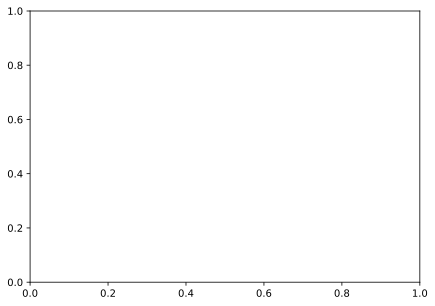

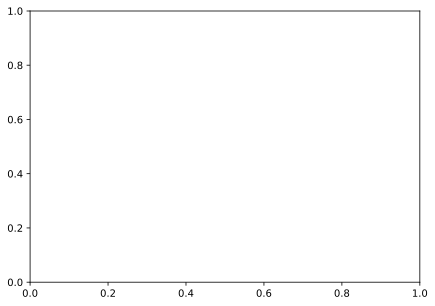

In [40]:
num_epochs = 10
train(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 3.2.7. Prediction

In [ ]:
def predict(net, test_iter, n=6): 
    for X, y in test_iter:
      break
    trues = get_pet_label(y)
    preds = get_pet_label(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 3, 350, 350)), 1, n, titles=titles[0:n])
    
predict(net, test_iter)

## 3.3. Concise Implementation of Softmax Regression (PyTorch)

In [41]:
import torch
from torch import nn
from d2l import torch as d2l

In [42]:
batch_size = 64
train_iter, test_iter = load_pet_img(batch_size)

### 3.3.1. Initialize Model Parameter

In [43]:
net = nn.Sequential(nn.Flatten(), nn.Linear(3*350*350, 37))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=367500, out_features=37, bias=True)
)

### 3.3.2. Softmax Implementation 

In [44]:
loss = nn.CrossEntropyLoss(reduction='none')

### 3.3.3. Optimization Algorithm

In [45]:
trainer = torch.optim.SGD(net.parameters(), lr=0.01)

### 3.3.4. Training

100%|██████████| 15/15 [22:30<00:00, 90.02s/it]

train loss : 2.8827585360278256 , train acc : 0.8847826086956522, test acc : 0.05723630417007359


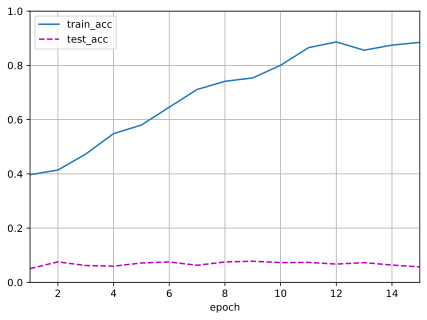

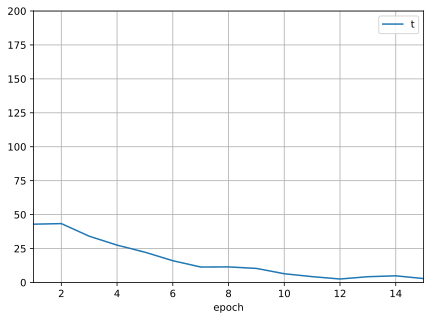

In [70]:
num_epochs = 15
train(net, train_iter, test_iter, loss, num_epochs, trainer)

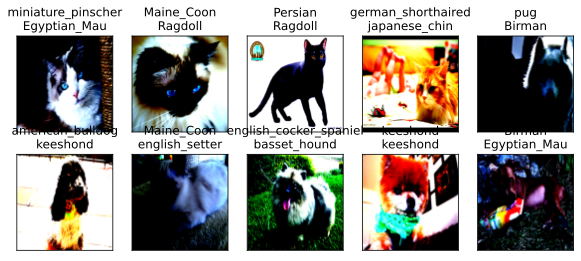

In [75]:
def predict(net, test_iter, n=10): 
    for X, y in test_iter:
      break
    trues = get_pet_label(y)
    preds = get_pet_label(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 3, 350, 350)), 2, 5, titles=titles[0:n])
    
predict(net, test_iter)